In [7]:
import pandas as pd
import numpy as np
import xarray as xr
import geopandas as gpd
from glob import glob

import matplotlib.pyplot as plt

import rioxarray as rio
from shapely.geometry import mapping

%matplotlib inline
# %matplotlib widget

In [ ]:
# import era5 data 
# merge all together 
# clip by HMA regions (pick one) 
# find median pixel (location)
# go to GEE find the date of snowline in that location (average over pixel area maybe?)
# 

### hma regions

In [14]:
hma = gpd.read_file('HMA_regions/HMA_regions.shp')
# hma.plot()

# as dataframe
hma_df = pd.DataFrame(hma) 
# hma_df.columns
hma_df.Name

0             Eastern Hindu Kush
1               Western Himalaya
2               Eastern Himalaya
3               Central Himalaya
4                      Karakoram
5                  Western Pamir
6                     Pamir Alay
7     Northern/Western Tien Shan
8             Dzhungarsky Alatau
9            Western Kunlun Shan
10               Nyainqentanglha
11            Gangdise Mountains
12                 Hengduan Shan
13    Tibetan Interior Mountains
14                 Tanggula Shan
15     Eastern Tibetan Mountains
16                   Qilian Shan
17           Eastern Kunlun Shan
18                    Altun Shan
19             Eastern Tien Shan
20             Central Tien Shan
21                 Eastern Pamir
Name: Name, dtype: object

## era5 for 2012 as an example! 

In [ ]:
'''
# read:
t2m = xr.open_dataset('era5_2m-temperature_hourly_2012.nc', decode_coords="all")
ssrd = xr.open_dataset('era5_surface-solar-radiation-downwards_hourly_2012.nc', decode_coords="all")
tcc = xr.open_dataset('era5_total-cloud-cover_hourly_2012.nc', decode_coords="all")
tp = xr.open_dataset('era5_total-precipitation_hourly_2012.nc', decode_coords="all")

# merge by coordinates 
# tutorial: https://docs.xarray.dev/en/stable/user-guide/combining.html
climate = xr.merge([t2m, tp, ssrd, tcc]) 
'''

### OR: era5 open all 

In [15]:
climate = xr.open_mfdataset('*.nc', decode_coords="all")
# cnange units (and overwrite the metadata with the units after)

#convert temperature K to C
climate['t2m']=climate.t2m-273.15
# precipotation m to mm 
climate['tp']=climate.tp * 1000
# radiation j/m2 to w/m2
# SSR [W/m2] = SSR [J/m^2] / (3600 seconds)
climate['ssrd'] = climate.ssrd / 3600

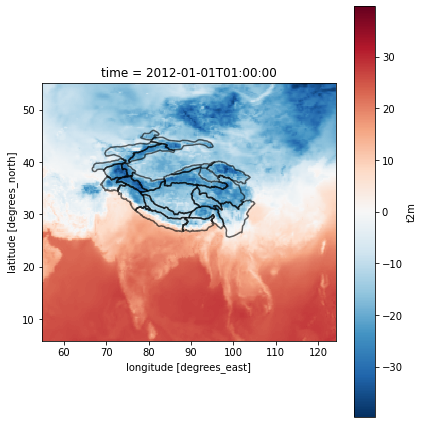

In [16]:
fig, ax = plt.subplots(figsize=(6, 6))
climate.t2m[1,:,:].plot()#palette='viridis')
hma.boundary.plot(ax=ax, alpha=.6, color='black')
fig.tight_layout()

In [18]:
''' change name of the mountain range here'''

roi = hma[hma['Name'] == 'Karakoram']
name = roi.Name
# karakoram.crs

In [17]:
# add crs to the dataset (netcdf file) - maybe this is not even needed 
climate = climate.rio.write_crs('EPSG:4326')

# clip using xarrayrio library:
roi_climate = climate.rio.clip(roi.geometry, roi.crs, drop=True, invert=False)

In [ ]:
# plot the selected shp 

# roi.boundary.plot()
# fig.tight_layout()

In [ ]:
# see how it looks like 
roi_climate.t2m[795,:,:].plot()
fig.tight_layout()

In [ ]:
# calculate how many era5 pix fall into the mountain range polygon

x = roi_climate.t2m[795,:,:].values.flatten()
x_count = roi_climate.t2m.median(dim='time').values.flatten().shape
print('total numnber of pixels within bbox:', x_count)

# without nans
x2 = x[~np.isnan(x)]
print('number of not-nan pixels:', x2.shape)


In [ ]:
# check for the median: 
if (len(x2) % 2) == 0:
    print ('EVEN number of not-nans -> ceiling/floor median')
else:print ('ODD number of not-nans -> regular median is ok')

### time dimention (-> value IN TIME)

In [ ]:
## "flatten" the data over time: reduce to smth (median temperatures/sum of precipitation over the year/etc) 

# statistics + keep the coordinates -> value IN TIME 
roi_climate_median = roi_climate.median(dim='time', keep_attrs = True, skipna=True)
roi_climate_sum = roi_climate.sum(dim='time', keep_attrs = True)


### space dimention (with pandas)

In [ ]:
# with pandas: 
# (1) compute median in time (-> on the previous step) 
# (2) convert to dataframe (with coords being index)
# (3) kick out nans and duplicates
# (4) compute median (or some other thing) across the table 
# (5) find the index of the value that eq=median


# to dataframe - median:
roi_climate_median_df = roi_climate_median.to_dataframe() # dimentions: number of catchments squared
roi_climate_median_df = roi_climate_median_df.dropna()
roi_climate_median_df = roi_climate_median_df.drop_duplicates()
# sanity check:
print('length of the df:', len(roi_climate_median_df))

# to dataframe - sum:
roi_climate_sum_df = roi_climate_sum.to_dataframe() # dimentions: number of catchments squared
roi_climate_sum_df = roi_climate_sum_df.dropna()
roi_climate_sum_df = roi_climate_sum_df.drop_duplicates()


 
roi_climate_median_df.head()

### median value of the not-nan pixels: 

In [ ]:
# since there are even number of pixels calculate medians in space this way: 

def median_ceil(values):
    values = sorted(values)
    values_len = len(values)
    middle = values_len//2
    return values[middle]

# t2m: 
t2m_median = roi_climate_median_df[roi_climate_median_df.t2m==median_ceil(values=roi_climate_median_df.t2m)]
tp_median = roi_climate_median_df[roi_climate_median_df.tp==median_ceil(values=roi_climate_median_df.tp)]

print('coordinates for the median temperature:', t2m_median.index) # 34.5, 78.5

print('coordinates for the median precipitation:', tp_median.index) # more then one 

In [ ]:
# go to gee and find images for the may snow line (snow presistence) 
# Snow persistence is defined as the fraction of time that a grid cell is covered by snow. 


In [ ]:
# roi_climate
# lon - 72
# lat - 37
# t2m_median['t2m'].iloc[0] - t2m_median 

### Get time-series of the temperature median

In [ ]:
# select data 
ts = roi_climate.sel(longitude = 78.5, latitude = 34.5, method = 'nearest')
# convert to df
ts_df = ts.to_dataframe()

In [ ]:
ts_df.head()

In [ ]:
fig, ax = plt.subplots(figsize = (8, 6))

ax.plot(ts_df.t2m)
ax.plot(ts_df.tp)
# ax2.plot(df.time, df.tcc, 'b-')ts_df.t2m.plot()

In [ ]:
fig, ax1 = plt.subplots(figsize = (18,6))

ax2 = ax1.twinx()

ax1.plot(ts_df.t2m, 'g')
ax2.plot(ts_df.tp, 'b')

ax1.set_ylabel('t2m', color='g', fontsize = 25)
ax2.set_ylabel('tp', color='b', fontsize = 25)

In [10]:
path

<xarray.Dataset>
Dimensions:    (longitude: 277, latitude: 197, time: 8760)
Coordinates:
  * longitude  (longitude) float32 55.0 55.25 55.5 55.75 ... 123.5 123.8 124.0
  * latitude   (latitude) float32 55.0 54.75 54.5 54.25 ... 6.75 6.5 6.25 6.0
  * time       (time) datetime64[ns] 1979-01-01 ... 1979-12-31T23:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2019-01-17 08:08:09 GMT by grib_to_netcdf-2.7.0: /opt/ecmwf...

In [ ]:
# indir_PK <- "r://external_data//CMIP6//monthly//merged-series//"

# "\\\\ad.geo.uu.nl\\FG\\Mountain Hydrology\\Data\\Repository\\external_data
# \\ERA5\\HMA\\netcdf\\monthly\\era5_total-precipitation_daysum_monsum_1979-2018.nc"

### xr.where() - way
#### spatial dimention (-> value IN SPACE + find location ) 

In [ ]:
# calculate the median value over the region -> vallue IN SPACE 
# then find it's location 
# https://docs.xarray.dev/en/latest/generated/xarray.DataArray.where.html

# roi_t2m_median = roi_climate_median.t2m.median()#dim = axes, keep_attrs = True)


In [ ]:
# with numpy (for T2M and TP): 

# t2m median vallue:
# t2m_median['t2m'].iloc[0] - value from median table: 
median_t2m_where = roi_climate_median.t2m.where(roi_climate_median.t2m == t2m_median['t2m'].iloc[0])


In [ ]:
median_t2m_where.plot()

In [ ]:
# type(roi_climate_median)
# type(median_t2m)
# ds
# t2m_median['t2m'].iloc[0] - t2m_median 

## multiple years: 
### calculate annual sum of precipitation, then take median vallue of the precipitation sum

In [11]:
# READ: 

temps   = xr.open_mfdataset("/Volumes/Data/Repository/external_data/ERA5/HMA/netcdf/hourly/2m-temperature/*.nc")
precips = xr.open_mfdataset("/Volumes/Data/Repository/external_data/ERA5/HMA/netcdf/hourly/total-precipitation/*.nc")

In [39]:
# CLIP with the same ROI as before: 


# add crs to the dataset (netcdf file) - maybe this is not even needed 
precips = precips.rio.write_crs('EPSG:4326')

# clip using xarrayrio library:
roi_precips = precips.rio.clip(roi.geometry, roi.crs, drop=True, invert=False)

In [25]:
# see how it looks like 
# roi_precips.tp[1,:,:].plot()
# fig.tight_layout()

In [61]:
# resample from hourly to annual: 

precip_sum = roi_precips.groupby('time.year').sum('time')

In [65]:
# statistics + keep the coordinates -> value IN TIME 

annual_median = precip_sum.median(dim='year', keep_attrs = True, skipna=True)


In [67]:
# annual_median.tp.plot()

In [70]:
annual_median_df = annual_median.to_dataframe()

KeyboardInterrupt: 

In [ ]:
annual_median_dа

In [ ]:
# resample things somehow? 

# resample for the YEAR resolution: 
# 1. precipitation: (1) take annual sum (2) ???

In [ ]:
# to select mnt-range by name see this: 
# https://github.com/pydata/xarray/issues/501